In [1]:
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt

train_eeg_dir = Path('../train_eegs/')
train_spectrogram_dir = Path('../train_spectrograms/')

test_dtypes={
    "eeg_label_offset_seconds": "Int64", 
    "spectrogram_label_offset_seconds": "Int64",
    "expert_consensus": "category"
    }

train_df = pd.read_csv('../train.csv', dtype=test_dtypes)
display(train_df.head(10))

submission_df = pd.read_csv('../sample_submission.csv')
display(submission_df.head())

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0,353733,0,0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6,353733,1,6,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8,353733,2,8,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18,353733,3,18,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24,353733,4,24,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26,353733,5,26,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30,353733,6,30,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36,353733,7,36,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40,353733,8,40,3388718494,42516,Seizure,3,0,0,0,0,0
9,2277392603,0,0,924234,0,0,1978807404,30539,GPD,0,0,5,0,1,5


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


In [2]:
def load_eeg_and_spectrogram(eeg_id, spec_id, eeg_offset, spec_offset):

    eeg_df = pd.read_parquet(train_eeg_dir/f"{eeg_id}.parquet")
    start_eeg = eeg_offset * 200
    end_eeg = start_eeg + (200 * 50)

    eeg = eeg_df.iloc[start_eeg:end_eeg,]

    spec_df = pd.read_parquet(train_spectrogram_dir/f"{spec_id}.parquet")
    start_spec = spec_offset
    end_spec = start_spec + 600

    spec = spec_df[(spec_df["time"] <= end_spec) & (spec_df["time"] >= start_spec)]

    return eeg, spec

from scipy.signal import butter, sosfilt

sos = butter(4, [1, 40], btype="bandpass", fs=200, output='sos')

def central_window_eeg(df, window_seconds=10):
    start = df.index[0]
    end = df.index[-1]
    mid = (start + end) / 2
    new_start = int(mid - window_seconds/2 * 200) - start + 1
    new_end = int(mid + window_seconds/2 * 200) - start + 1
    return df.iloc[new_start:new_end]

def plot_eeg(df, bp_filter=True):

    fig, axs = plt.subplots(20, 1, figsize=(15, 10), sharex=True)
    
    for i, ax in enumerate(axs):
        
        if bp_filter:
            ts_signal = sosfilt(sos, df.iloc[:,i])
        else:
            ts_signal = df.iloc[:,i]

        ax.plot(ts_signal, color="black")
        ax.set_ylabel(df.columns[i], rotation=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
    
    fig.tight_layout()
    plt.show()

def plot_spec(df):

    fig, axs = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)

    prefixes = ['LL', 'RL', 'LP', 'RP']

    for ax, prefix in zip(axs.flatten(), prefixes):
        cols = df.filter(regex=f"^{prefix}_").columns
        ax.imshow(df[cols].T, origin="lower", norm="log", cmap="plasma", interpolation="none")
        ax.set_title(prefix, fontsize=12, fontweight="bold")
        ax.set_yticks(np.arange(0, 101, 25.))
        ax.set_yticklabels([0, 5, 10, 15, 20])
        ax.set_xticks(np.arange(0, 301, 75.))
        ax.set_xticklabels(range(df.iloc[0, 0], df.iloc[-1, 0], (df.iloc[-1, 0]-df.iloc[0, 0])//4))

    for ax in axs[:, 0]:
        ax.set_ylabel("Frequency (Hz)")
    for ax in axs[-1, :]:
        ax.set_xlabel("Time (s)")

    fig.tight_layout()
    plt.show()

In [13]:
choose_row = 1010

eeg_id, spec_id, eeg_offset, spec_offset = train_df.loc[choose_row, ['eeg_id', 'spectrogram_id', 'eeg_label_offset_seconds', 'spectrogram_label_offset_seconds']]

votes = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote" ]

print(f"eeg_id: {eeg_id}, spec_id: {spec_id}, eeg_offset: {eeg_offset}, spec_offset: {spec_offset}")
print(f"patient_id: {train_df.loc[choose_row, 'patient_id']}")
print(f"label_id: {train_df.loc[choose_row, 'label_id']}")
print(f"expert_consensus: {train_df.loc[choose_row, 'expert_consensus']}")
print(f"Votes: ")
for vote in votes:
    print(f"{vote}: {train_df.loc[choose_row, vote]}")


df_eeg, df_spec = load_eeg_and_spectrogram(eeg_id, spec_id, eeg_offset, spec_offset)

eeg_id: 3088095149, spec_id: 13143748, eeg_offset: 100, spec_offset: 1654
patient_id: 34998
label_id: 4010647066
expert_consensus: GRDA
Votes: 
seizure_vote: 0
lpd_vote: 0
gpd_vote: 0
lrda_vote: 0
grda_vote: 2
other_vote: 2


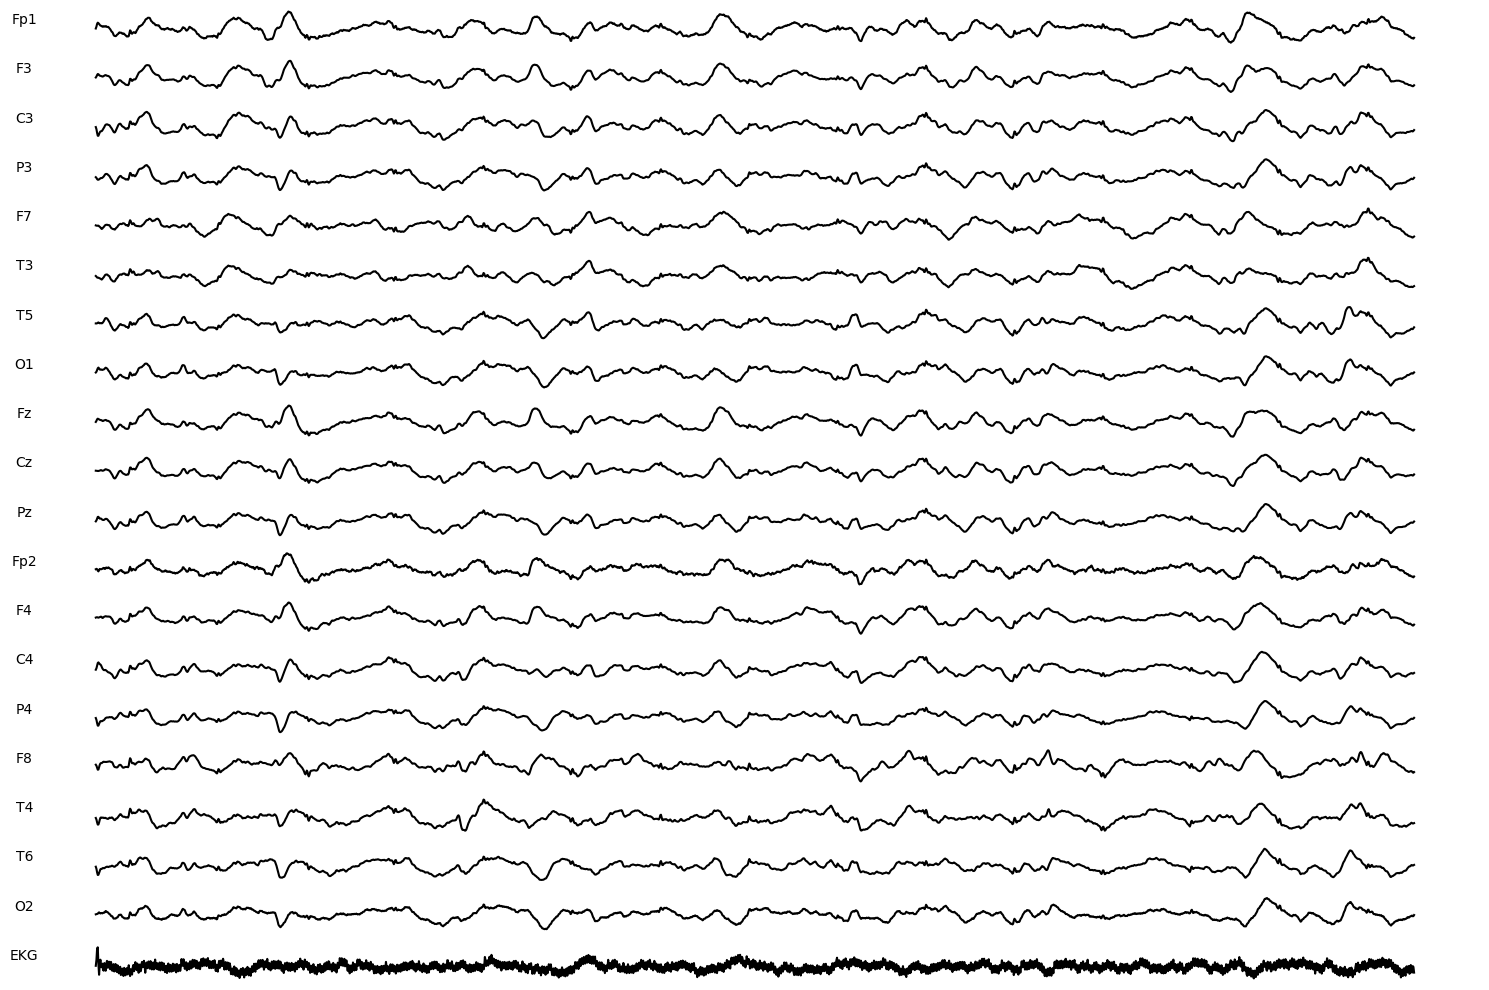

In [14]:
plot_eeg(central_window_eeg(df_eeg, 10), bp_filter=True)

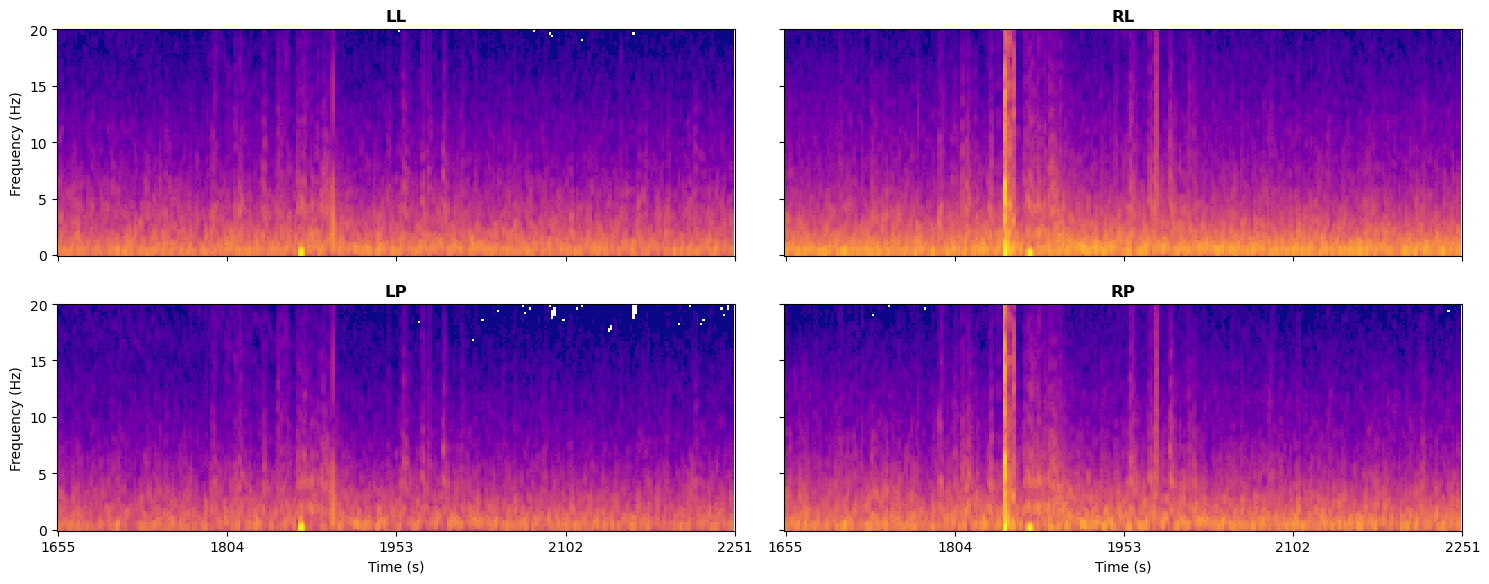

In [15]:
plot_spec(df_spec)